In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
!tree --filelimit=30

.
├── classifier_benchmark_RandomForest.pkl
├── classifier_grid_RF.pkl
├── classifier_MajorityVote_RF-Bagging-Adaboost_2.pkl
├── classifier_MajorityVote_RF-Bagging-Adaboost.pkl
├── classifier_RandomForest_n_estimator-800_depth-20.pkl
├── features_submission_prepared.csv
├── features_submission_prepared_for_benchmark.csv
├── Pumpitup_data_preparation_for_benchmark.ipynb
├── Pumpitup_data_preparation.ipynb
├── PumpItUp.ipynb
├── PumpItUp-learning.ipynb
├── results_MajorityVote_2.csv
├── results_MajorityVote.csv
├── results_RandomForest-09-august-2017.csv
├── results_RandomForest-benchmark.csv
├── results_Randomforest_Benchmark.csv
├── results_RandomForest-n_estimators-800.csv
├── SubmissionFormat.csv
├── submission_set_features.csv
├── training_data_for_benchmark.csv
├── training_data_prepared.csv
├── training_set.csv
└── training_set_labels.csv

0 directories, 23 files


# Importation of prepared data #

In [3]:
data_PumpItUp = pd.read_csv("training_data_prepared.csv")

# Learning #
----------------------------------------
I have tried several models for classification (Random Forest, K-neigbors, Adaboost, XGBoost, SVM, etc.). Random forest was the one that gave the best initial result with 76 % accuracy without fine-tuning and without all the features. Thus, I decided to do a grid search with Random forest to acheive the maximal accuracy. 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, log_loss

In [5]:
X = data_PumpItUp.drop(["status_group"],axis=1)
y = data_PumpItUp["status_group"]
X = X.fillna(X.mean())

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.3, random_state=102)

 ## Random Forest - Benchmark##

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
classifier_RandomForest = RandomForestClassifier()
classifier_RandomForest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [9]:
y_pred_RandomForest = classifier_RandomForest.predict(X_test)

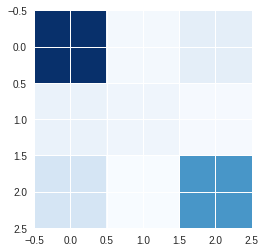

In [10]:
cnf_matrix = confusion_matrix(y_test, y_pred_RandomForest)
plt.imshow(cnf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.show()

In [11]:
print(classification_report(y_test,y_pred_RandomForest))

                         precision    recall  f1-score   support

             functional       0.79      0.87      0.83      9685
functional needs repair       0.51      0.35      0.42      1314
         non functional       0.82      0.76      0.79      6821

            avg / total       0.78      0.79      0.78     17820



## Grid search for Random Forest ##

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
n_estimators = [20,100,400,800,1200]
max_depth = [15,20, 40]
param_grid = { "n_estimators"      : n_estimators,
           "max_depth"         : max_depth
             }


In [14]:
classifier_RF = RandomForestClassifier()
grid_search_RF = GridSearchCV(classifier_RF, param_grid, n_jobs =8,cv=5)

In [15]:
grid_search_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'n_estimators': [20, 100, 400, 800, 1200], 'max_depth': [15, 20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [16]:
print(grid_search_RF.best_params_)

{'max_depth': 20, 'n_estimators': 800}


In [17]:
y_pred_RandomForest_grid = grid_search_RF.predict(X_test)

In [18]:
print(classification_report(y_test,y_pred_RandomForest_grid))

                         precision    recall  f1-score   support

             functional       0.78      0.91      0.84      9685
functional needs repair       0.62      0.27      0.38      1314
         non functional       0.85      0.74      0.80      6821

            avg / total       0.80      0.80      0.79     17820



In [19]:
scores = grid_search_RF.cv_results_['mean_test_score'].reshape(len(max_depth),len(n_estimators))

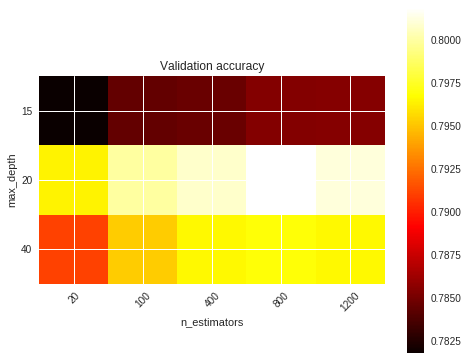

In [20]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(n_estimators)), n_estimators, rotation=45)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('Validation accuracy')
plt.show()

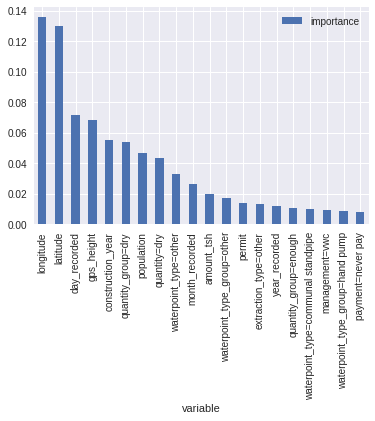

In [21]:
df_features_importance = pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(classifier_RandomForest.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

df_features_importance.plot.bar(x=df_features_importance['variable'])

In [22]:
import pickle
# save the classifier
with open('classifier_grid_RF.pkl', 'wb') as fid:
    pickle.dump(grid_search_RF, fid)

# Submission #

In [23]:
X_submission = pd.read_csv("features_submission_prepared.csv")
#X_submission = X_submission.fillna(X_submission.mean())

In [24]:
prediction_submission =classifier_RandomForest.predict(X_submission)

## Merge des resultats pour soumission et enregistrement ##

For the submission, I will need the id colums that has been removed in the initial preparation of the data. The predicted label colums also doesn't have a name. The name "status_group" in then added to satifisfy the submission format. 

In [25]:
features_submission_PumpItUp = pd.read_csv("submission_set_features.csv")

In [26]:
df1 = features_submission_PumpItUp[["id"]]
df2 = pd.DataFrame(prediction_submission)
df1.reset_index(drop=True, inplace=True)

results = pd.concat( [df1, df2], axis=1) 

In [27]:
results.reset_index(drop=True, inplace=True)
results.columns
results.rename(columns={0: 'status_group'}, inplace=True)

In [28]:
results.to_csv("results_RandomForest-09-august-2017.csv",index=False,index_label=False)

In [29]:
results.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
